# Analyse Réseau : Top 5 Clients par Pays
## Visualisation des Relations Pays-Clients

Ce notebook crée un graphe réseau montrant les 5 meilleurs clients de chaque pays en fonction du nombre total de commandes.

### 1. Importation des bibliothèques

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Configuration pour un meilleur affichage
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print("Bibliothèques chargées avec succès!")
print(f"NetworkX version: {nx.__version__}")
print(f"Pandas version: {pd.__version__}")

Bibliothèques chargées avec succès!
NetworkX version: 3.5
Pandas version: 2.2.3


### 2. Chargement des données

In [2]:
# Chargement des trois tables CSV
# Assurez-vous que les fichiers CSV sont dans le même dossier que ce notebook

# Table des faits
fait = pd.read_csv('../data/Fait_Commandes.csv')

# Table dimension Client
dim_client = pd.read_csv('../data/Dim_Client.csv')

# Table dimension Employee
dim_employee = pd.read_csv('../data/Dim_Employee.csv')

print("Données chargées avec succès!")
print(f"Fait: {fait.shape}")
print(f"Dim_Client: {dim_client.shape}")
print(f"Dim_Employee: {dim_employee.shape}")

Données chargées avec succès!
Fait: (4938, 6)
Dim_Client: (120, 6)
Dim_Employee: (58, 8)


### 3. Préparation des données - Jointures

In [3]:
# Renommage des colonnes si nécessaire
fait = fait.rename(columns={
    'Dim_Client.id_seqClient': 'id_seqClient',
    'Dim_Employee.id_seqEmployee': 'id_seqEmployee',
    'Somme de nbr_commandes_livrees': 'nbr_commande_livrees',
    'Somme de nbr_commandes_non_livrees': 'nbr_commande_non_livrees'
})

# Jointure avec la dimension Client pour obtenir CompanyName et Country
dataset = fait.merge(dim_client[['id_seqClient', 'CompanyName', 'Country']], 
                     on='id_seqClient', 
                     how='left')

# Suppression des doublons
dataset = dataset.drop_duplicates()

# Calcul du total des commandes
dataset['Total Commandes'] = dataset['nbr_commande_livrees'] + dataset['nbr_commande_non_livrees']

print("Dataset après jointures:")
print(dataset.head())
print(f"\nShape: {dataset.shape}")
print(f"\nColonnes disponibles: {dataset.columns.tolist()}")

Dataset après jointures:
   idSeqFait  Dim_Temps.id_temps  id_seqClient  id_seqEmployee  \
0          1                   1            85              17   
1          2                   1            85              18   
2          3                   1            85              19   
3          4                   1            85              20   
4          5                   1            85              21   

   nbr_commande_livrees  nbr_commande_non_livrees                CompanyName  \
0                     1                         0  Vins et alcools Chevalier   
1                     1                         0  Vins et alcools Chevalier   
2                     1                         0  Vins et alcools Chevalier   
3                     1                         0  Vins et alcools Chevalier   
4                     1                         0  Vins et alcools Chevalier   

  Country  Total Commandes  
0  France                1  
1  France                1  
2  France 

### 4. Exploration des données

In [4]:
# Vérification des données
print("Nombre de pays uniques:", dataset['Country'].nunique())
print("\nListe des pays:")
print(dataset['Country'].value_counts())

print("\n" + "="*50)
print("Statistiques sur le total des commandes:")
print(dataset['Total Commandes'].describe())

Nombre de pays uniques: 21

Liste des pays:
Country
USA            902
Germany        665
Brazil         476
France         435
UK             313
Venezuela      246
Austria        244
Sweden         203
Mexico         169
Italy          167
Canada         162
Ireland        125
Belgium        124
Spain          123
Finland        119
Denmark        110
Switzerland    106
Argentina      102
Portugal        73
Norway          41
Poland          33
Name: count, dtype: int64

Statistiques sur le total des commandes:
count    4938.000000
mean        1.023896
std         0.152742
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: Total Commandes, dtype: float64


### 5. Traitement des données pour le graphe réseau

In [5]:
# Copie du dataset
df = dataset.copy()

# Total commandes
df["Total_Commandes"] = df["Total Commandes"]

# Agrégation par Country et CompanyName
agg = df.groupby(["Country", "CompanyName"], as_index=False)["Total_Commandes"].sum()

print("Données agrégées:")
print(agg.head(10))
print(f"\nNombre total de relations Pays-Client: {len(agg)}")

Données agrégées:
     Country                 CompanyName  Total_Commandes
0  Argentina  Cactus Comidas para llevar               41
1  Argentina      Océano Atlántico Ltda.               36
2  Argentina               Rancho grande               25
3    Austria                Ernst Handel              179
4    Austria            Piccolo und mehr               72
5    Belgium                Maison Dewey               48
6    Belgium            Suprêmes délices               76
7     Brazil            Comércio Mineiro               24
8     Brazil          Familia Arquibaldo               48
9     Brazil         Gourmet Lanchonetes               53

Nombre total de relations Pays-Client: 104


In [6]:
# Sélection du Top 5 clients par pays
top_clients = agg.sort_values(["Country", "Total_Commandes"], ascending=[True, False])
top_clients = top_clients.groupby("Country").head(5)

print(f"Nombre de relations après sélection Top 5: {len(top_clients)}")
print(f"\nNombre de pays représentés: {top_clients['Country'].nunique()}")
print("\nAperçu du Top 5 par pays:")
print(top_clients.head(15))

Nombre de relations après sélection Top 5: 64

Nombre de pays représentés: 21

Aperçu du Top 5 par pays:
      Country                    CompanyName  Total_Commandes
0   Argentina     Cactus Comidas para llevar               41
1   Argentina         Océano Atlántico Ltda.               36
2   Argentina                  Rancho grande               25
3     Austria                   Ernst Handel              179
4     Austria               Piccolo und mehr               72
6     Belgium               Suprêmes délices               76
5     Belgium                   Maison Dewey               48
12     Brazil                  Queen Cozinha               90
10     Brazil                  Hanari Carnes               70
13     Brazil             Ricardo Adocicados               60
15     Brazil         Wellington Importadora               56
9      Brazil            Gourmet Lanchonetes               53
16     Canada          Bottom-Dollar Markets               81
18     Canada              

### 6. Affichage des Top 5 par pays

In [7]:
# Affichage détaillé par pays
for country in top_clients['Country'].unique():
    print(f"\n{'='*60}")
    print(f"Top 5 Clients - {country}")
    print(f"{'='*60}")
    country_data = top_clients[top_clients['Country'] == country].sort_values('Total_Commandes', ascending=False)
    for idx, row in country_data.iterrows():
        print(f"  {row['CompanyName']:30s} : {row['Total_Commandes']:4.0f} commandes")


Top 5 Clients - Argentina
  Cactus Comidas para llevar     :   41 commandes
  Océano Atlántico Ltda.         :   36 commandes
  Rancho grande                  :   25 commandes

Top 5 Clients - Austria
  Ernst Handel                   :  179 commandes
  Piccolo und mehr               :   72 commandes

Top 5 Clients - Belgium
  Suprêmes délices               :   76 commandes
  Maison Dewey                   :   48 commandes

Top 5 Clients - Brazil
  Queen Cozinha                  :   90 commandes
  Hanari Carnes                  :   70 commandes
  Ricardo Adocicados             :   60 commandes
  Wellington Importadora         :   56 commandes
  Gourmet Lanchonetes            :   53 commandes

Top 5 Clients - Canada
  Bottom-Dollar Markets          :   81 commandes
  Mère Paillarde                 :   68 commandes
  Laughing Bacchus Wine Cellars  :   21 commandes

Top 5 Clients - Denmark
  Simons bistro                  :   57 commandes
  Vaffeljernet                   :   56 commandes


### 7. Construction du graphe réseau

In [8]:
# Création du graphe
G = nx.Graph()

# Ajout des arêtes (edges) entre pays et clients
for _, row in top_clients.iterrows():
    country = row["Country"]
    client = row["CompanyName"]
    total = row["Total_Commandes"]
    G.add_edge(country, client, weight=total)

print(f"Graphe créé avec succès!")
print(f"Nombre de nœuds: {G.number_of_nodes()}")
print(f"Nombre d'arêtes: {G.number_of_edges()}")
print(f"\nNœuds (Pays + Clients): {list(G.nodes())[:10]}...")

Graphe créé avec succès!
Nombre de nœuds: 85
Nombre d'arêtes: 64

Nœuds (Pays + Clients): ['Argentina', 'Cactus Comidas para llevar', 'Océano Atlántico Ltda.', 'Rancho grande', 'Austria', 'Ernst Handel', 'Piccolo und mehr', 'Belgium', 'Suprêmes délices', 'Maison Dewey']...


### 8. Configuration du layout du graphe

In [9]:
# --- PARAMÈTRES DE LAYOUT ---
radius_client = 0.5          # distance standard entre pays et ses clients
country_spacing = 3.0        # espacement entre pays dans le graphe

# --- POSITION DES PAYS ---
countries = top_clients["Country"].unique()

# layout circulaire de base
base_pos = nx.circular_layout(countries)

# multiplier les distances pour éviter que les clusters se chevauchent
country_pos = {c: (base_pos[c][0] * country_spacing,
                   base_pos[c][1] * country_spacing)
               for c in countries}

# --- PLACEMENT DES CLIENTS ---
pos = {}

for country in countries:
    cx, cy = country_pos[country]
    pos[country] = (cx, cy)

    clients = top_clients[top_clients["Country"] == country]["CompanyName"].tolist()
    n = len(clients)

    for i, client in enumerate(clients):
        angle = 2 * np.pi * i / n
        pos[client] = (
            cx + radius_client * np.cos(angle),
            cy + radius_client * np.sin(angle),
        )

print(f"Positions calculées pour {len(pos)} nœuds")
print(f"Nombre de pays: {len(countries)}")
print(f"Pays: {list(countries)}")

Positions calculées pour 85 nœuds
Nombre de pays: 21
Pays: ['Argentina', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Denmark', 'Finland', 'France', 'Germany', 'Ireland', 'Italy', 'Mexico', 'Norway', 'Poland', 'Portugal', 'Spain', 'Sweden', 'Switzerland', 'UK', 'USA', 'Venezuela']


### 9. Visualisation du graphe réseau

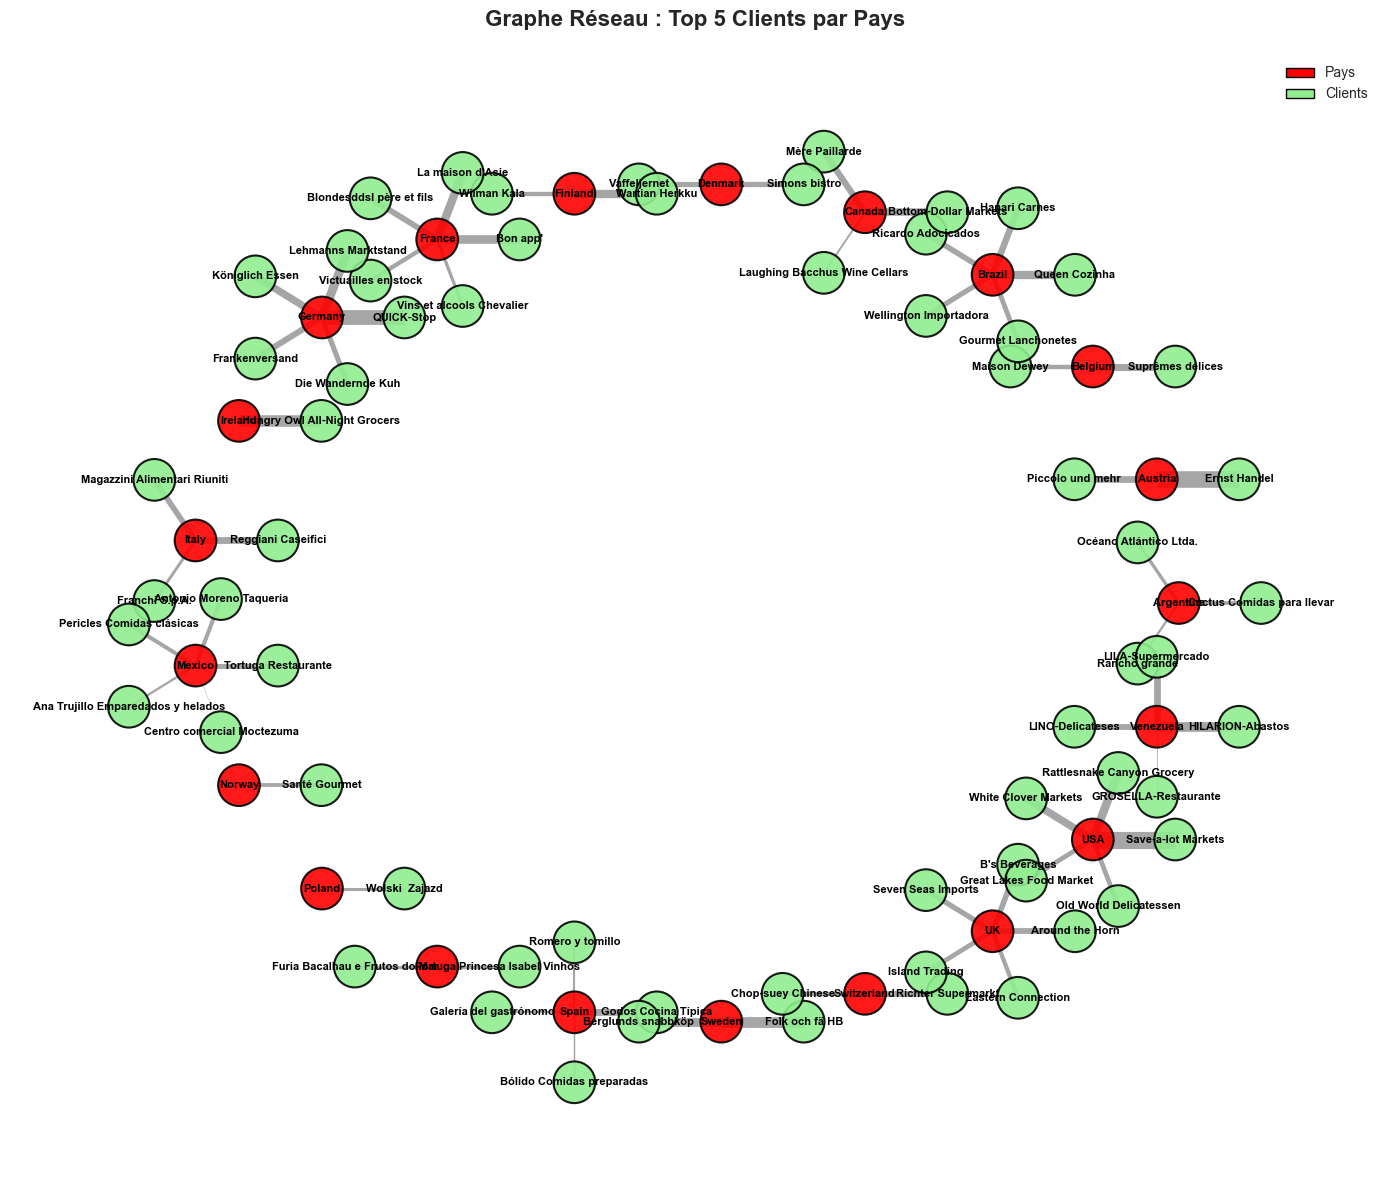

In [10]:
# --- DESSIN DU GRAPHE ---
plt.figure(figsize=(14, 12))

edges = G.edges()
weights = [G[u][v]['weight'] / 15 for u, v in edges]

# Couleurs séparées pour pays et clients
node_colors = [
    "red" if node in countries else "lightgreen"
    for node in G.nodes()
]

# Dessin des nœuds
nx.draw_networkx_nodes(G, pos, node_size=900, node_color=node_colors, alpha=0.9, edgecolors='black', linewidths=1.5)

# Dessin des arêtes
nx.draw_networkx_edges(G, pos, width=weights, alpha=0.7, edge_color='gray')

# Dessin des labels
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

plt.title("Graphe Réseau : Top 5 Clients par Pays", fontsize=16, fontweight='bold', pad=20)
plt.axis("off")
plt.tight_layout()

# Ajout d'une légende
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='Pays'),
    Patch(facecolor='lightgreen', edgecolor='black', label='Clients')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.show()

### 10. Analyses complémentaires

In [11]:
# Statistiques du graphe
print("=== STATISTIQUES DU GRAPHE ===")
print(f"\nDegré moyen des nœuds: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
print(f"\nDegré des nœuds pays (nombre de clients):")
for country in countries:
    print(f"  {country}: {G.degree(country)} clients")

print(f"\nPoids total des arêtes: {sum([G[u][v]['weight'] for u, v in G.edges()]):.0f} commandes")

=== STATISTIQUES DU GRAPHE ===

Degré moyen des nœuds: 1.51

Degré des nœuds pays (nombre de clients):
  Argentina: 3 clients
  Austria: 2 clients
  Belgium: 2 clients
  Brazil: 5 clients
  Canada: 3 clients
  Denmark: 2 clients
  Finland: 2 clients
  France: 5 clients
  Germany: 5 clients
  Ireland: 1 clients
  Italy: 3 clients
  Mexico: 5 clients
  Norway: 1 clients
  Poland: 1 clients
  Portugal: 2 clients
  Spain: 4 clients
  Sweden: 2 clients
  Switzerland: 2 clients
  UK: 5 clients
  USA: 5 clients
  Venezuela: 4 clients

Poids total des arêtes: 4064 commandes


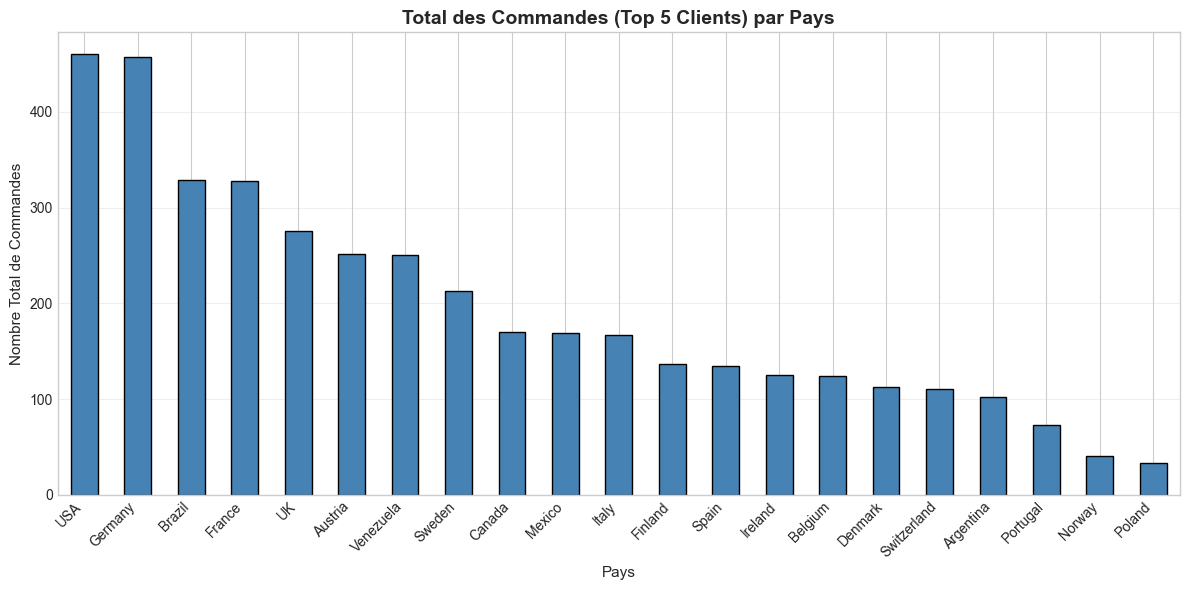


Total des commandes par pays:
Country
USA            460
Germany        457
Brazil         329
France         328
UK             276
Austria        251
Venezuela      250
Sweden         213
Canada         170
Mexico         169
Italy          167
Finland        137
Spain          135
Ireland        125
Belgium        124
Denmark        113
Switzerland    111
Argentina      102
Portugal        73
Norway          41
Poland          33
Name: Total_Commandes, dtype: int64


In [12]:
# Distribution des commandes par pays
commandes_par_pays = top_clients.groupby('Country')['Total_Commandes'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
commandes_par_pays.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Total des Commandes (Top 5 Clients) par Pays', fontsize=14, fontweight='bold')
plt.xlabel('Pays', fontsize=11)
plt.ylabel('Nombre Total de Commandes', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTotal des commandes par pays:")
print(commandes_par_pays)

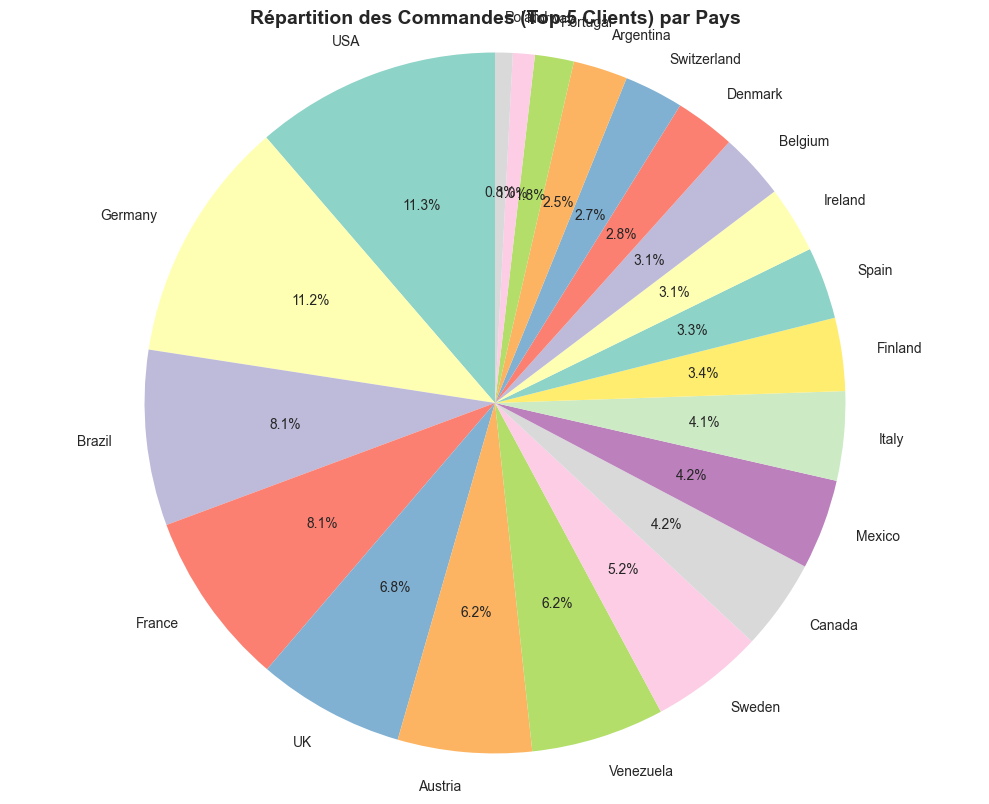

In [13]:
# Graphique en camembert - Répartition par pays
plt.figure(figsize=(10, 8))
plt.pie(commandes_par_pays, labels=commandes_par_pays.index, autopct='%1.1f%%', 
        startangle=90, colors=plt.cm.Set3.colors)
plt.title('Répartition des Commandes (Top 5 Clients) par Pays', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

### 11. Graphe réseau alternatif sous forme html pour interagire 

In [ ]:
### 11. Graphe réseau INTERACTIF avec Pyvis (Drag & Drop complet)



from pyvis.network import Network
import networkx as nx

# --- CRÉATION DU GRAPHE INTERACTIF AVEC PYVIS ---

# Créer un réseau Pyvis
net = Network(
    height='800px', 
    width='100%', 
    bgcolor='#ffffff', 
    font_color='black',
    notebook=True,  # Pour affichage dans Jupyter
    heading='Graphe Reseau : Top 5 Clients par Pays (Drag & Drop)',
    cdn_resources="remote"
)

# Configuration de la physique pour un meilleur rendu
net.set_options("""
{
  "physics": {
    "enabled": true,
    "forceAtlas2Based": {
      "gravitationalConstant": -50,
      "centralGravity": 0.01,
      "springLength": 200,
      "springConstant": 0.08
    },
    "maxVelocity": 50,
    "solver": "forceAtlas2Based",
    "timestep": 0.35,
    "stabilization": {
      "enabled": true,
      "iterations": 100
    }
  },
  "interaction": {
    "dragNodes": true,
    "dragView": true,
    "zoomView": true,
    "hover": true,
    "navigationButtons": true,
    "keyboard": {
      "enabled": true
    }
  }
}
""")

# Ajouter les nœuds avec leurs attributs
for node in G.nodes():
    if node in countries:
        # Nœud Pays (rouge)
        net.add_node(
            node, 
            label=node,
            color='#ff4444',
            size=30,
            title=f"<b>Pays: {node}</b><br>Nombre de clients: {G.degree(node)}",
            shape='dot',
            font={'size': 16, 'color': 'black', 'bold': True}
        )
    else:
        # Nœud Client (vert)
        # Trouver le pays associé et le nombre de commandes
        country_node = list(G.neighbors(node))[0]
        commandes = G[node][country_node]['weight']
        
        net.add_node(
            node,
            label=node,
            color='#90EE90',
            size=20,
            title=f"<b>Client: {node}</b><br>Pays: {country_node}<br>Commandes: {commandes:.0f}",
            shape='dot',
            font={'size': 12, 'color': 'black'}
        )

# Ajouter les arêtes avec poids
for edge in G.edges():
    weight = G[edge[0]][edge[1]]['weight']
    net.add_edge(
        edge[0], 
        edge[1], 
        value=weight/10,  # Épaisseur proportionnelle
        title=f"Commandes: {weight:.0f}",
        color='#888888'
    )

# Afficher le graphe dans le notebook
# Utiliser cdn_resources='local' pour éviter les problèmes avec Live Server
net.write_html('graphe_interactif.html', local=True, notebook=False)
print("Fichier créé : graphe_interactif.html")

# Si vous êtes dans Jupyter, décommentez la ligne suivante pour afficher directement :
# net.show('graphe_interactif.html')

print("\n✅ Graphe interactif créé avec succès!")
print("\n📊 Le graphe a été sauvegardé dans 'graphe_interactif.html'")
print("\n💡 Fonctionnalités disponibles:")
print("   ✓ Cliquez et déplacez les nœuds individuellement (DRAG & DROP)")
print("   ✓ Survolez les nœuds pour voir les détails")
print("   ✓ Zoom avec la molette de la souris")
print("   ✓ Déplacez la vue entière avec clic droit")
print("   ✓ Boutons de navigation en bas à droite")
print("   ✓ Double-clic sur un nœud pour le centrer")
print("\n🔴 Nœuds rouges = Pays")
print("🟢 Nœuds verts = Clients")
print("\n📁 Vous pouvez aussi ouvrir le fichier 'graphe_interactif.html' dans votre navigateur")


# --- VERSION ALTERNATIVE AVEC LAYOUT PERSONNALISÉ ---
print("\n" + "="*70)
print("VERSION 2 : Avec layout circulaire personnalisé")
print("="*70)

# Créer un deuxième réseau avec positions fixes
net2 = Network(
    height='800px', 
    width='100%', 
    bgcolor='#ffffff', 
    font_color='black',
    notebook=True,
    heading='Graphe Reseau avec Layout Circulaire (Drag & Drop)',
    cdn_resources="remote"
)

# Désactiver la physique pour garder le layout circulaire
net2.set_options("""
{
  "physics": {
    "enabled": false
  },
  "interaction": {
    "dragNodes": true,
    "dragView": true,
    "zoomView": true,
    "hover": true,
    "navigationButtons": true
  }
}
""")

# Calculer les positions circulaires
radius_client = 150
country_spacing = 400

countries_list = top_clients["Country"].unique()
base_pos = nx.circular_layout(countries_list)

# Positions pour les pays
country_positions = {
    c: (base_pos[c][0] * country_spacing, base_pos[c][1] * country_spacing)
    for c in countries_list
}

# Ajouter les nœuds avec positions fixes
for country in countries_list:
    cx, cy = country_positions[country]
    
    # Ajouter le nœud pays
    net2.add_node(
        country,
        label=country,
        x=cx,
        y=cy,
        color='#ff4444',
        size=30,
        title=f"<b>Pays: {country}</b><br>Nombre de clients: {len(top_clients[top_clients['Country'] == country])}",
        shape='dot',
        font={'size': 16, 'color': 'black', 'bold': True},
        fixed=False  # Permet le drag & drop
    )
    
    # Ajouter les clients autour du pays
    clients = top_clients[top_clients["Country"] == country]["CompanyName"].tolist()
    n = len(clients)
    
    for i, client in enumerate(clients):
        angle = 2 * np.pi * i / n
        client_x = cx + radius_client * np.cos(angle)
        client_y = cy + radius_client * np.sin(angle)
        
        commandes = top_clients[
            (top_clients['Country'] == country) & 
            (top_clients['CompanyName'] == client)
        ]['Total_Commandes'].values[0]
        
        net2.add_node(
            client,
            label=client,
            x=client_x,
            y=client_y,
            color='#90EE90',
            size=20,
            title=f"<b>Client: {client}</b><br>Pays: {country}<br>Commandes: {commandes:.0f}",
            shape='dot',
            font={'size': 12, 'color': 'black'},
            fixed=False
        )
        
        # Ajouter l'arête
        net2.add_edge(
            country,
            client,
            value=commandes/10,
            title=f"Commandes: {commandes:.0f}",
            color='#888888'
        )

# Sauvegarder et afficher
net2.write_html('graphe_circulaire_interactif.html', local=True,  notebook=False)
print("Fichier créé : graphe_circulaire_interactif.html")

print("\n✅ Graphe circulaire créé avec succès!")
print("📁 Sauvegardé dans 'graphe_circulaire_interactif.html'")
print("\n🎯 Ce layout maintient la structure circulaire tout en permettant le drag & drop!")


# --- COMPARAISON DES FICHIERS CRÉÉS ---
print("\n" + "="*70)
print("📂 FICHIERS CRÉÉS:")
print("="*70)
print("1. graphe_interactif.html")
print("   → Layout dynamique avec physique activée")
print("   → Les nœuds se repositionnent automatiquement")
print("")
print("2. graphe_circulaire_interactif.html")
print("   → Layout circulaire fixe (comme votre code original)")
print("   → Structure claire par pays")
print("   → Drag & drop disponible pour réorganiser manuellement")
print("="*70)

Fichier créé : graphe_interactif.html

✅ Graphe interactif créé avec succès!

📊 Le graphe a été sauvegardé dans 'graphe_interactif.html'

💡 Fonctionnalités disponibles:
   ✓ Cliquez et déplacez les nœuds individuellement (DRAG & DROP)
   ✓ Survolez les nœuds pour voir les détails
   ✓ Zoom avec la molette de la souris
   ✓ Déplacez la vue entière avec clic droit
   ✓ Boutons de navigation en bas à droite
   ✓ Double-clic sur un nœud pour le centrer

🔴 Nœuds rouges = Pays
🟢 Nœuds verts = Clients

📁 Vous pouvez aussi ouvrir le fichier 'graphe_interactif.html' dans votre navigateur

VERSION 2 : Avec layout circulaire personnalisé
Fichier créé : graphe_circulaire_interactif.html

✅ Graphe circulaire créé avec succès!
📁 Sauvegardé dans 'graphe_circulaire_interactif.html'

🎯 Ce layout maintient la structure circulaire tout en permettant le drag & drop!

📂 FICHIERS CRÉÉS:
1. graphe_interactif.html
   → Layout dynamique avec physique activée
   → Les nœuds se repositionnent automatiquement

2.